<a href="https://colab.research.google.com/github/mo2026bialy/signal-project/blob/main/notebook5cecf94bfc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mohamedasem318_wesad_full_dataset_path = kagglehub.dataset_download('mohamedasem318/wesad-full-dataset')

print('Data source import complete.')


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd

base_path = "/kaggle/input/wesad-full-dataset/WESAD"
subjects = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
            'S11', 'S13', 'S14', 'S15', 'S16', 'S17']

combined_data = []
combined_labels = []

for subject in subjects:
    file_path = os.path.join(base_path, subject, f"{subject}.pkl")

    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')

        chest = data['signal']['chest']
        label = data['label']

        # أسماء الإشارات الصحيحة
        try:
            acc = chest['ACC']
            ecg = chest['ECG']
            eda = chest['EDA']
            emg = chest['EMG']
            resp = chest['Resp']
            temp = chest['Temp']

            # ندمج الإشارات في مصفوفة واحدة
            merged = np.hstack((acc, ecg, eda, emg, resp, temp))

            if merged.shape[0] != label.shape[0]:
                print(f"⚠ {subject} فيه mismatch بين الداتا والليبلز.")
                continue

            combined_data.append(merged)
            combined_labels.append(label)
            print(f"✅ {subject} تم معالجته بنجاح.")

        except Exception as e:
            print(f"❌ {subject} حصلت فيه مشكلة:", e)

# دمج كل المشاركين
if len(combined_data) > 0:
    X = np.concatenate(combined_data, axis=0)
    y = np.concatenate(combined_labels, axis=0)
    print("✅ تم دمج كل إشارات chest بنجاح!")
    print("X shape:", X.shape)
    print("y shape:", y.shape)
else:
    print("❌ مفيش ولا عينة تم قبولها.")

In [ ]:
# تعديل أسماء الأعمدة لتتناسب مع عدد الأعمدة في X
column_names = ['ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']

# تحويل X و y إلى DataFrame مع إضافة أسماء الأعمدة
df = pd.DataFrame(X, columns=column_names)

# إضافة العمود الخاص بالتسمية
df['label'] = y

# تحويل التصنيفات كما طلبت
df['label'] = df['label'].apply(lambda x: 1 if x == 2 else 0 if x in [0, 1, 3, 4] else x)

# حذف الصفوف التي تحتوي على التصنيفات 5, 6, 7
df = df[~df['label'].isin([5, 6, 7])]

# فصل المدخلات عن التصنيفات بعد الفلترة
X_filtered = df.drop('label', axis=1).values
y_filtered = df['label'].values

# التحقق من الشكل الجديد
print(f"✅ تم فلترة البيانات بنجاح!")
print(f"X_filtered shape: {X_filtered.shape}")
print(f"y_filtered shape: {y_filtered.shape}")

✅ تم فلترة البيانات بنجاح!
X_filtered shape: (59125500, 8)
y_filtered shape: (59125500,)


In [ ]:
df.shape

(59125500, 9)

In [ ]:
print(df.head())

    ACC_x   ACC_y   ACC_z       ECG       EDA       EMG      Resp       Temp  \
0  0.9554 -0.2220 -0.5580  0.021423  5.250549 -0.004440 -1.148987  30.120758   
1  0.9258 -0.2216 -0.5538  0.020325  5.267334  0.004349 -1.124573  30.129517   
2  0.9082 -0.2196 -0.5392  0.016525  5.243301  0.005173 -1.152039  30.138214   
3  0.8974 -0.2102 -0.5122  0.016708  5.249405  0.007187 -1.158142  30.129517   
4  0.8882 -0.2036 -0.4824  0.011673  5.286407 -0.015152 -1.161194  30.130951   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  


In [ ]:
# حساب عدد التصنيفات الفريدة
unique_labels = df['label'].unique()

# حساب عدد التصنيفات الفريدة
num_unique_labels = len(unique_labels)

print(f"عدد التصنيفات الفريدة: {num_unique_labels}")
print(f"التصنيفات الفريدة: {unique_labels}")

عدد التصنيفات الفريدة: 2
التصنيفات الفريدة: [0 1]


In [ ]:
import numpy as np

def create_windows(X, y, window_size=42000):
    """
    تقسيم البيانات إلى نوافذ.

    X: البيانات (الميزات) - الشكل المتوقع: (عدد العينات, عدد الميزات)
    y: التصنيفات - الشكل المتوقع: (عدد العينات, 1) أو (عدد العينات,)
    window_size: عدد العينات داخل كل نافذة (700Hz * 60s = 42000)
    """
    windows_X = []
    windows_y = []

    for i in range(0, len(X) - window_size, window_size):
        window_X = X[i:i+window_size]
        window_y = y[i:i+window_size]

        # استخدام التصنيف الأكثر تكرارًا في النافذة
        label = np.bincount(window_y.flatten()).argmax()

        windows_X.append(window_X)
        windows_y.append(label)

    windows_X = np.array(windows_X)
    windows_y = np.array(windows_y)

    return windows_X, windows_y

# إعدادات التردد والمدة
frequency = 700  # هرتز
window_seconds = 60  # ثانية
window_size = frequency * window_seconds  # 42000

# تطبيق عملية التقسيم
X_windows, y_windows = create_windows(X_filtered, y_filtered, window_size)

# عرض النتائج بشكل مرتب
print(f"windows number: {X_windows.shape[0]}")
print(f": {X_windows[0].shape}")  # شكل أول نافذة للتحقق (مثلاً: (42000, 8))
print(f"label distribution: {np.unique(y_windows, return_counts=True)}")

windows number: 1407
: (42000, 8)
label distribution: (array([0, 1]), array([1241,  166]))


In [ ]:
import numpy as np

def extract_features(X_windows):
    features = []
    for window in X_windows:
        window_features = []
        for ch in range(window.shape[1]):
            signal = window[:, ch]
            mean = np.mean(signal)
            std = np.std(signal)
            min_val = np.min(signal)
            max_val = np.max(signal)
            median = np.median(signal)
            energy = np.sum(signal ** 2)
            zero_crossings = ((signal[:-1] * signal[1:]) < 0).sum()
            window_features.extend([mean, std, min_val, max_val, median, energy, zero_crossings])
        features.append(window_features)
    return np.array(features)

# مثال على استخدام الدالة:
# (بافتراض أن X_windows موجود بالفعل)
X_features = extract_features(X_windows)
print("✅ تم استخراج الميزات.")
print("شكل مصفوفة الميزات:", X_features.shape)

✅ تم استخراج الميزات.
شكل مصفوفة الميزات: (1407, 56)


✅ Accuracy: 0.9361702127659575

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.96       249
           1       0.94      0.48      0.64        33

    accuracy                           0.94       282
   macro avg       0.94      0.74      0.80       282
weighted avg       0.94      0.94      0.93       282



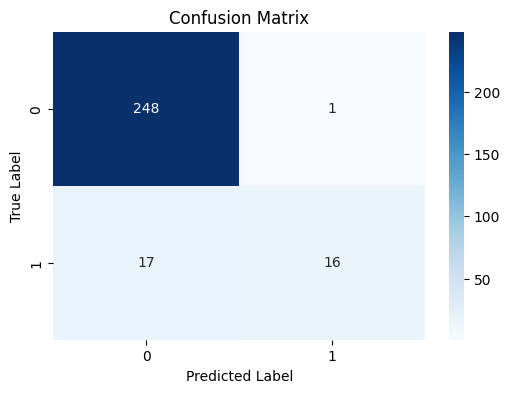

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# تقسيم البيانات إلى تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(X_features, y_windows, test_size=0.2, random_state=42, stratify=y_windows)

# إنشاء وتدريب الموديل
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# التنبؤ على بيانات الاختبار
y_pred = model.predict(X_test)

# تقييم الأداء
accuracy = accuracy_score(y_test, y_pred)
print("✅ Accuracy:", accuracy)
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))

# رسم الـ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()